# 1. Importing Necessary Library

In [2]:
# notebooks/1_Data_Preprocessing_EDA.ipynb
import sys
import os

# Go up to project root from the current notebook location
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# 1. Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from src.data_processing import calculate_daily_returns, calculate_rolling_volatility


# 2 . Load Merged Data and Others.

In [3]:
# 2. Load processed data
merged_data = pd.read_csv("../data/processed/merged_data.csv", index_col="datetime", parse_dates=True)
returns = pd.read_csv("../data/processed/features/daily_returns.csv", index_col="datetime", parse_dates=True)
volatility = pd.read_csv("../data/processed/features/rolling_volatility.csv", index_col="datetime", parse_dates=True)

# 3 . Basic Info and Checking Missing values

In [4]:
merged_data.info

<bound method DataFrame.info of                  TSLA        BND         SPY
datetime                                    
2025-08-07  322.26999  73.580000  632.250000
2025-08-06  319.91000  73.610000  632.780030
2025-08-05  308.72000  73.670000  627.969970
2025-08-04  309.26001  73.640000  631.169980
2025-08-01  302.63000  73.590000  621.719970
...               ...        ...         ...
2015-07-08   16.99733  81.690000  204.530000
2015-07-07   17.85867  81.460000  208.020004
2015-07-06   18.64800  81.380000  206.720000
2015-07-02   18.66800  81.099998  207.310000
2015-07-01   17.94333  80.900000  207.500000

[2541 rows x 3 columns]>

In [5]:
merged_data.head()

,TSLA,BND,SPY
datetime,,,
2025-08-07,322.26999,73.58,632.25000
2025-08-06,319.91000,73.61,632.78003
2025-08-05,308.72000,73.67,627.96997
2025-08-04,309.26001,73.64,631.16998
2025-08-01,302.63000,73.59,621.71997


In [6]:
returns.head()

,TSLA,BND,SPY
datetime,,,
2025-08-06,-0.007323,0.000408,0.000838
2025-08-05,-0.034979,0.000815,-0.007601
2025-08-04,0.001749,-0.000407,0.005096
2025-08-01,-0.021438,-0.000679,-0.014972
2025-07-31,0.018637,-0.005300,0.016664


In [7]:
volatility.head(50)

,TSLA,BND,SPY
datetime,,,
2025-08-06,NaN,NaN,NaN
2025-08-05,NaN,NaN,NaN
2025-08-04,NaN,NaN,NaN
2025-08-01,NaN,NaN,NaN
2025-07-31,NaN,NaN,NaN
2025-07-30,NaN,NaN,NaN
2025-07-29,NaN,NaN,NaN
2025-07-28,NaN,NaN,NaN
2025-07-25,NaN,NaN,NaN


## Checking & Imputing Missing values for each Data set.

In [8]:
# Data Quality Check
print("=== Missing Values Check ===")
missing_values = merged_data.isnull().sum()
print("Missing values in price data:\n", missing_values)

missing_returns = returns.isnull().sum()
print("\nMissing values in returns:\n", missing_returns)

missing_volatility = volatility.isnull().sum()
print("\nMissing values in volatility:\n", missing_volatility)

# Handle Missing Values - Enhanced Treatment
def handle_missing(df, name):
    """Enhanced missing value treatment with reporting"""
    initial_count = df.isnull().sum().sum()
    
    # Forward fill (carry last known value forward)
    df_ffilled = df.ffill()
    
    # Backward fill (for any remaining NAs at start)
    df_cleaned = df_ffilled.bfill()
    
    final_count = df_cleaned.isnull().sum().sum()
    print(f"\n{name}: Filled {initial_count} missing values")
    
    if final_count > 0:
        print(f"Warning: {final_count} missing values remain")
        # For time series, consider interpolation
        df_cleaned = df_cleaned.interpolate(method='time')
        print(f"After interpolation: {df_cleaned.isnull().sum().sum()} missing remain")
    
    return df_cleaned

# Apply to all datasets
merged_data = handle_missing(merged_data, "Price Data")
returns = handle_missing(returns, "Returns Data") 
volatility = handle_missing(volatility, "Volatility Data")

# Validate Cleaning
print("\n=== After Cleaning ===")
print("Missing in prices:", merged_data.isnull().sum().sum())
print("Missing in returns:", returns.isnull().sum().sum())
print("Missing in volatility:", volatility.isnull().sum().sum())


=== Missing Values Check ===
Missing values in price data:
 TSLA    0
BND     0
SPY     0
dtype: int64

Missing values in returns:
 TSLA    0
BND     0
SPY     0
dtype: int64

Missing values in volatility:
 TSLA    20
BND     20
SPY     20
dtype: int64

Price Data: Filled 0 missing values

Returns Data: Filled 0 missing values

Volatility Data: Filled 60 missing values

=== After Cleaning ===
Missing in prices: 0
Missing in returns: 0
Missing in volatility: 0


# 4 . Basic Statistics

In [9]:
#  Basic Statistics
print("=== Basic Statistics ===")
print("Merged Prices:\n", merged_data.describe())
print("\nDaily Returns:\n", returns.describe())
print("\nRolling Volatility:\n", volatility.describe())

=== Basic Statistics ===
Merged Prices:
               TSLA          BND          SPY
count  2541.000000  2541.000000  2541.000000
mean    132.387749    79.630649   356.074050
std     121.087754     5.371976   118.845581
min       9.578000    68.040001   182.860000
25%      18.982000    73.760000   258.670010
50%      98.432670    81.000000   329.059998
75%     237.039993    83.940000   438.549990
max     479.859990    89.480000   637.099976

Daily Returns:
               TSLA          BND          SPY
count  2540.000000  2540.000000  2540.000000
mean     -0.000446     0.000043    -0.000372
std       0.037245     0.003502     0.011600
min      -0.184938    -0.040492    -0.095038
25%      -0.019344    -0.001719    -0.005954
50%      -0.001260    -0.000119    -0.000597
75%       0.017683     0.001644     0.003770
max       0.266830     0.057513     0.122868

Rolling Volatility:
               TSLA          BND          SPY
count  2540.000000  2540.000000  2540.000000
mean      0.545667  

# 5. Price Trend Visualization

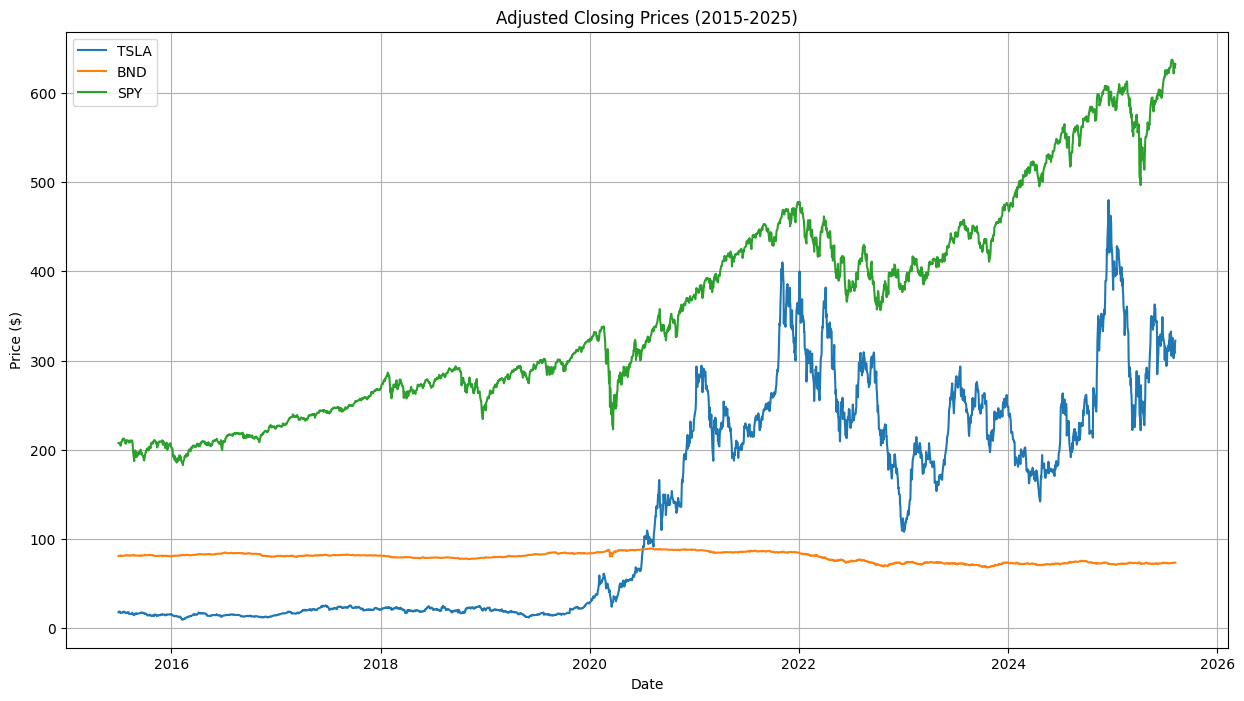

In [11]:
# Price Trends Visualization
plt.figure(figsize=(15, 8))
for column in merged_data.columns:
    plt.plot(merged_data.index, merged_data[column], label=column)
plt.title('Adjusted Closing Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.savefig('../outputs/visualizations/price_trends.png')
plt.show()

# 6 . Returns Distribution

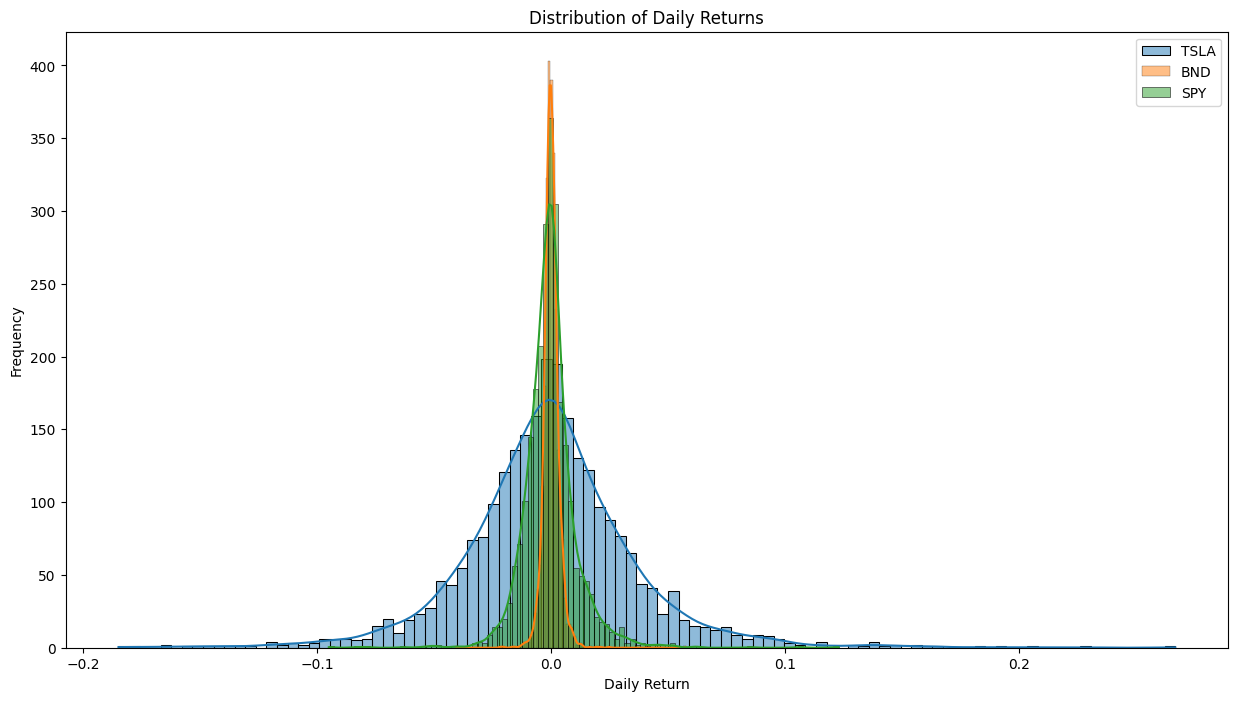

In [12]:
# Returns Distribution
plt.figure(figsize=(15, 8))
for column in returns.columns:
    sns.histplot(returns[column], bins=100, label=column, alpha=0.5, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('../outputs/visualizations/returns_distribution.png')
plt.show()


# 7 . Volatility Analysis

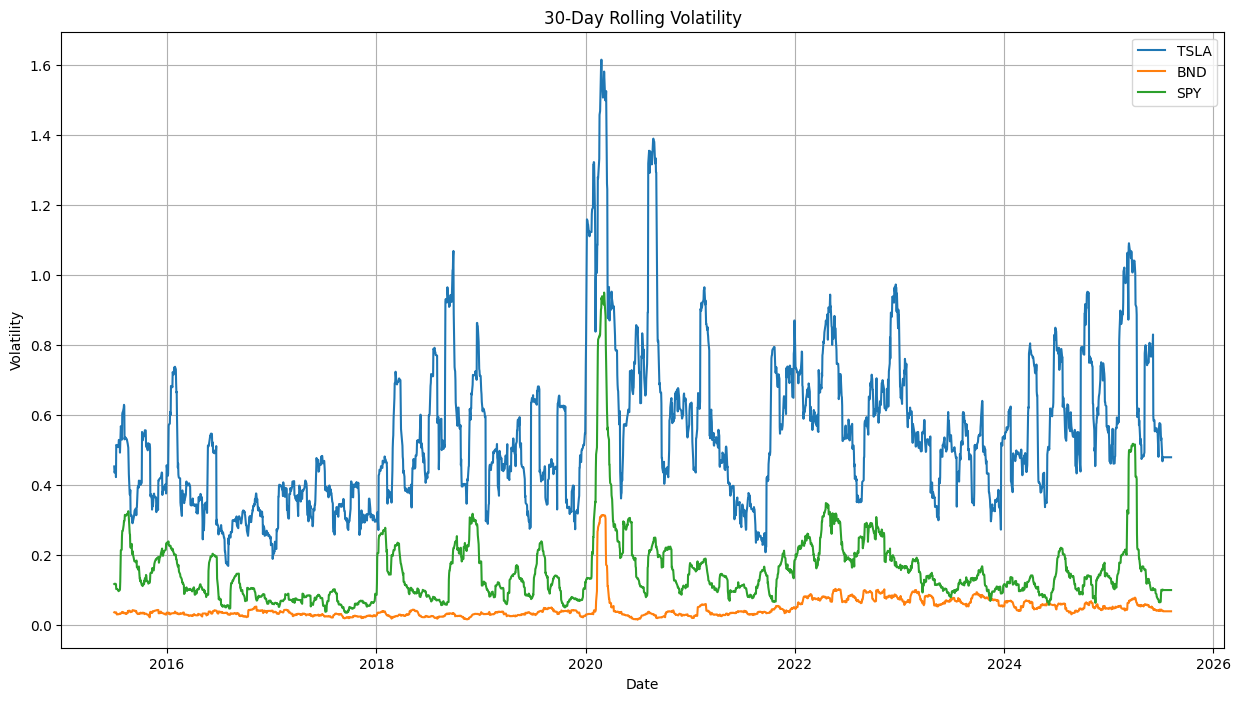

In [13]:
# Volatility Analysis
plt.figure(figsize=(15, 8))
for column in volatility.columns:
    plt.plot(volatility.index, volatility[column], label=column)
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.savefig('../outputs/visualizations/rolling_volatility.png')
plt.show()

# 8 . Stationarity Tests

In [14]:
#  Stationarity Tests
def test_stationarity(series, name):
    print(f"\nADF Test for {name}:")
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1] < 0.05  # Return True if stationary

print("\n=== Stationarity Tests ===")
for ticker in ['TSLA', 'BND', 'SPY']:
    is_stationary = test_stationarity(merged_data[ticker], f"{ticker} Prices")
    print(f"{ticker} Prices are {'stationary' if is_stationary else 'not stationary'}")
    
    is_stationary = test_stationarity(returns[ticker], f"{ticker} Returns")
    print(f"{ticker} Returns are {'stationary' if is_stationary else 'not stationary'}\n")



=== Stationarity Tests ===

ADF Test for TSLA Prices:
ADF Statistic: -1.878033822322628
p-value: 0.3424641937670781
Critical Values:
	1%: -3.432954851668868
	5%: -2.862690812247962
	10%: -2.5673826214832887
TSLA Prices are not stationary

ADF Test for TSLA Returns:
ADF Statistic: -11.780047814915271
p-value: 1.040081348771491e-21
Critical Values:
	1%: -3.432946577138947
	5%: -2.8626871581881708
	10%: -2.5673806760176046
TSLA Returns are stationary


ADF Test for BND Prices:
ADF Statistic: -1.4317860893176237
p-value: 0.5669462078784903
Critical Values:
	1%: -3.4329404056582598
	5%: -2.862684432835292
	10%: -2.567379225007826
BND Prices are not stationary

ADF Test for BND Returns:
ADF Statistic: -14.388253629175184
p-value: 8.914055178709803e-27
Critical Values:
	1%: -3.4329404056582598
	5%: -2.862684432835292
	10%: -2.567379225007826
BND Returns are stationary


ADF Test for SPY Prices:
ADF Statistic: -2.087978819586699
p-value: 0.24937577159851676
Critical Values:
	1%: -3.4329363076

# 9 . Risk Metrics Calculation

In [15]:

# Risk Metrics Calculation
def calculate_risk_metrics(returns):
    metrics = {}
    for ticker in returns.columns:
        # Annualized metrics
        annual_return = returns[ticker].mean() * 252
        annual_volatility = returns[ticker].std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_volatility
        
        # Value at Risk (95%)
        var_95 = np.percentile(returns[ticker], 5)
        
        metrics[ticker] = {
            'Annualized Return': annual_return,
            'Annualized Volatility': annual_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'VaR (95%)': var_95
        }
    return pd.DataFrame(metrics)

risk_metrics = calculate_risk_metrics(returns)
print("\n=== Risk Metrics ===")
display(risk_metrics)
risk_metrics.to_csv('../outputs/portfolios/risk_metrics.csv')


=== Risk Metrics ===


,TSLA,BND,SPY
Annualized Return,-0.112499,0.010950,-0.093651
Annualized Volatility,0.591239,0.055595,0.184151
Sharpe Ratio,-0.190277,0.196959,-0.508556
VaR (95%),-0.056300,-0.004637,-0.015787
